In [182]:
import pulp
import csv
# Define the optimization problem
prob = pulp.LpProblem("EV_Charging_Station_Optimization", pulp.LpMaximize)

# Charging station parameters
n_chargers = 2  # number of chargers at the station
n_plugs_per_charger = 2  # number of plugs per charger
max_total_power = 100  # kW, maximum total power for the station
max_charger_power = 20  # kW, maximum power per charger
max_plug_power = 10  # kW, maximum power per plug

# Electric vehicle parameters 
n_vehicles = 10
arrival_times = [1, 4, 2, 4, 3, 6, 7, 4, 6, 8]  # arrival time for each vehicle
departure_times = [12, 9, 10, 8, 15, 16, 19, 13, 15, 14] # departure time for each vehicle
required_energy = [45] * n_vehicles  # kWh, energy required for each vehicle
initial_battery_state = [0] * n_vehicles  # kWh, battery state at arrival
charging_efficiency = [1] * n_vehicles   # charging efficiency (assumed 100% for simplicity)

# Electric vehicle parameters 
# n_vehicles = 30
# arrival_times = [1] * n_vehicles  # arrival time for each vehicle
# departure_times = [12] * n_vehicles # departure time for each vehicle
# required_energy = [45] * n_vehicles  # kWh, energy required for each vehicle
# initial_battery_state = [0] * n_vehicles  # kWh, battery state at arrival
# charging_efficiency = [1] * n_vehicles  # charging efficiency (assumed 100% for simplicity)

# Define decision variables
# P_vehicle_t indicates the power assigned to a vehicle at a specific plug in a specific time period
P_vehicle_t = pulp.LpVariable.dicts("P_vehicle_t", 
                                    ((v, c, p, t) for v in range(n_vehicles) 
                                     for c in range(n_chargers) 
                                     for p in range(n_plugs_per_charger) 
                                     for t in range(24)),  # Use 96 for 15-minute intervals
                                    lowBound=0, upBound=max_plug_power, cat='Continuous')

# Binary variable for time-dependent plug assignment
vehicle_assigned = pulp.LpVariable.dicts("vehicle_assigned", 
                                         ((v, c, p, t) for v in range(n_vehicles)
                                          for c in range(n_chargers)
                                          for p in range(n_plugs_per_charger)
                                          for t in range(24)), 
                                         cat='Binary')

# Binary variable indicating if a vehicle is assigned to a plug of a charger (not time-dependent)
plug_assigned = pulp.LpVariable.dicts("plug_assigned", 
                                      ((v, c, p) for v in range(n_vehicles)
                                       for c in range(n_chargers)
                                       for p in range(n_plugs_per_charger)), cat='Binary')

# Binary variables that indicate if a vehicle is charged to 100%
fully_charged = pulp.LpVariable.dicts("fully_charged", range(n_vehicles), cat='Binary')

# Objective function: Maximize the number of vehicles that reach 100% charge
prob += pulp.lpSum(fully_charged[v] for v in range(n_vehicles)), "Maximize_Fully_Charged_Vehicles"

# Constraint 1: Vehicles can only charge between their arrival and departure times
for v in range(n_vehicles):
    for t in range(24):  
        if t < arrival_times[v] or t >= departure_times[v]:
            for c in range(n_chargers):
                for p in range(n_plugs_per_charger):
                    prob += P_vehicle_t[v, c, p, t] == 0
                    prob += vehicle_assigned[v, c, p, t] == 0
                    
# Constraint 2: Energy required by each vehicle
for v in range(n_vehicles):
    required_energy_for_vehicle = (required_energy[v] - initial_battery_state[v]) / charging_efficiency[v]
    prob += pulp.lpSum(P_vehicle_t[v, c, p, t] for c in range(n_chargers)
                       for p in range(n_plugs_per_charger)
                       for t in range(arrival_times[v], departure_times[v])) == required_energy_for_vehicle * fully_charged[v]

# Constraint 3: Each vehicle can only be assigned to one plug for the entire session
for v in range(n_vehicles):
    prob += pulp.lpSum(plug_assigned[v, c, p] for c in range(n_chargers) for p in range(n_plugs_per_charger)) <= 1

# Constraint 4: Only one vehicle can be charging at any plug at the same time
for c in range(n_chargers):
    for p in range(n_plugs_per_charger):
        for t in range(24):  # or 96 for 15-minute intervals
            prob += pulp.lpSum(vehicle_assigned[v, c, p, t] for v in range(n_vehicles)) <= 1

# Constraint 5: Vehicle can only charge on the plug to which it is assigned
for v in range(n_vehicles):
    for c in range(n_chargers):
        for p in range(n_plugs_per_charger):
            for t in range(24): 
                prob += vehicle_assigned[v, c, p, t] <= plug_assigned[v, c, p]

# Constraint 6: Power can only be assigned if the vehicle is assigned to the plug at that time
for v in range(n_vehicles):
    for c in range(n_chargers):
        for p in range(n_plugs_per_charger):
            for t in range(24):  
                prob += P_vehicle_t[v, c, p, t] <= max_plug_power * vehicle_assigned[v, c, p, t]

# Constraint 7: Maximum power per charger
for c in range(n_chargers):
    for t in range(24):
        prob += pulp.lpSum(P_vehicle_t[v, c, p, t] for v in range(n_vehicles) for p in range(n_plugs_per_charger)) <= max_charger_power


# Solve the problem
prob.solve(pulp.PULP_CBC_CMD(timeLimit=20,gapRel=0.05))

# Print the results
print("Problem Status:", pulp.LpStatus[prob.status])

# 1. Collect vehicle-to-plug assignments
vehicle_plug_assignments = []

# Loop through each vehicle and check which charger and plug it has been assigned to
for v in range(n_vehicles):
    for c in range(n_chargers):
        for p in range(n_plugs_per_charger):
            if plug_assigned[v, c, p].varValue == 1:  # If vehicle is assigned to this charger and plug
                # Print the result
                print(f"Vehicle {v} is assigned to charger {c}, plug {p} for the entire session.")
                
                # Add to the list for exporting
                vehicle_plug_assignments.append([
                    v,  # Vehicle ID
                    c,  # Charger
                    p,  # Plug
                    arrival_times[v],  # Arrival
                    departure_times[v],  # Departure
                    required_energy[v]  # Required Energy
                ])

# 2. Export vehicle-to-plug assignments to CSV
with open('vehicle_plug_assignments.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Vehicle", "Charger", "Plug", "Arrival", "Departure", "RequiredEnergy"])
    writer.writerows(vehicle_plug_assignments)

print("Vehicle-to-plug assignments exported to 'vehicle_plug_assignments.csv'")

# Print vehicles that reached 100% charge
for v in range(n_vehicles):
    if fully_charged[v].varValue == 1:
        print(f"Vehicle {v} reached 100% charge.")
    else:
        print(f"Vehicle {v} did not reach 100% charge.")

# Print vehicle-to-plug assignments
for v in range(n_vehicles):
    for c in range(n_chargers):
        for p in range(n_plugs_per_charger):
            if plug_assigned[v, c, p].varValue == 1:
                print(f"Vehicle {v} is assigned to charger {c}, plug {p} for the entire session.")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/adolfo/Documents/optimizer-AF/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/_h/s142zshd62dgzph0g945khy40000gn/T/815f2b0a41f549cba59d412de1b32cb2-pulp.mps -max -sec 20 -ratio 0.05 -timeMode elapsed -branch -printingOptions all -solution /var/folders/_h/s142zshd62dgzph0g945khy40000gn/T/815f2b0a41f549cba59d412de1b32cb2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 3321 COLUMNS
At line 12738 RHS
At line 16055 BOUNDS
At line 18026 ENDATA
Problem MODEL has 3316 rows, 1970 columns and 7386 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 20
ratioGap was changed from 0 to 0.05
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9.88889 - 0.01 seconds
Cgl0002I 616 variables fixed
Cgl0008I 40 inequality constraints converted to equality constraints
Cgl0004I processed model has 

In [183]:
import csv

# Prepare results for export

# 1. Power delivered by each plug of each charger over time
plug_power_results = []

# Loop over time, chargers, and plugs to collect power delivered per plug
for c in range(n_chargers):
    for p in range(n_plugs_per_charger):
        for t in range(24):  # or 96 for 15-minute intervals
            total_power = sum(P_vehicle_t[v, c, p, t].varValue for v in range(n_vehicles))
            plug_power_results.append([c, p, t, total_power])

# 2. Power delivered to each EV over time
ev_power_results = []

# Loop over time and vehicles to collect power delivered per EV
for v in range(n_vehicles):
    for t in range(24):  # or 96 for 15-minute intervals
        total_power = sum(P_vehicle_t[v, c, p, t].varValue for c in range(n_chargers) for p in range(n_plugs_per_charger))
        ev_power_results.append([v, t, total_power])

# Export results to CSV

# 1. Export plug power results #also add what vehicles are assigned to which charger,plug
with open('plug_power_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Charger", "Plug", "Hour", "Power (kW)"])
    writer.writerows(plug_power_results)

print("Plug power results exported to 'plug_power_results.csv'")

# 2. Export EV power results
with open('ev_power_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Vehicle", "Hour", "Power (kW)"])
    writer.writerows(ev_power_results)

print("EV power results exported to 'ev_power_results.csv'")

Plug power results exported to 'plug_power_results.csv'
EV power results exported to 'ev_power_results.csv'


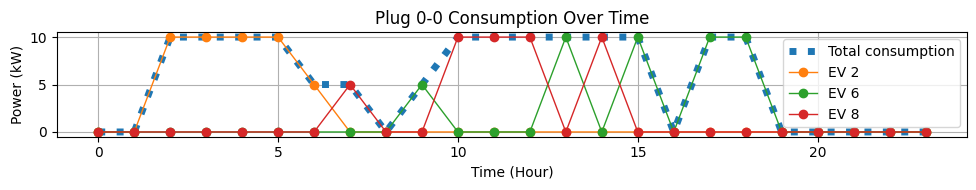

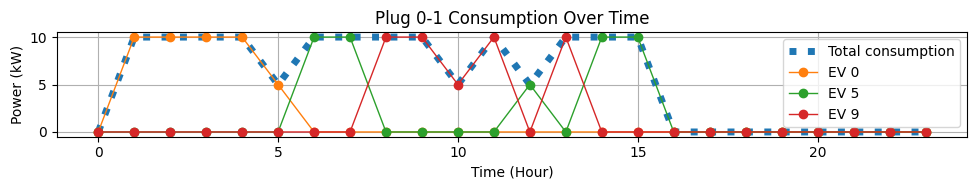

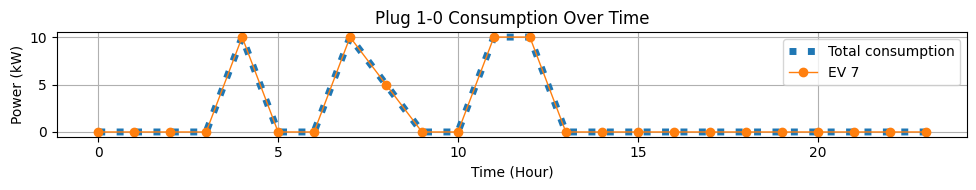

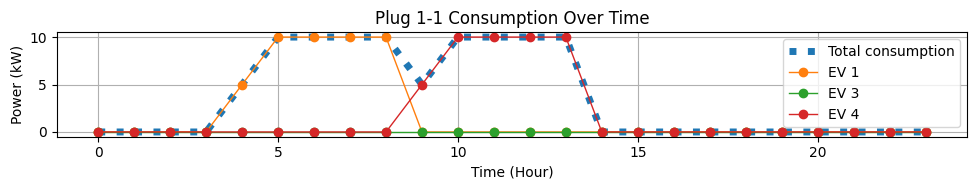

In [184]:
import pandas as pd 
import matplotlib.pyplot as plt

# Load the CSV files for plug power and EV power
plug_power_df = pd.read_csv('plug_power_results.csv')
ev_power_df = pd.read_csv('ev_power_results.csv')

# Create a dictionary to store data for each plug
plug_ev_data = {}

# Loop over each plug and filter EVs based on assignment in plug_assigned
for (charger, plug), group in plug_power_df.groupby(['Charger', 'Plug']):
    plug_ev_data[(charger, plug)] = pd.DataFrame(columns=['Total consumption'])
    
    # Add total consumption to the DataFrame
    plug_ev_data[(charger, plug)]['Total consumption'] = group['Power (kW)'].values
    
    # Loop through each EV and only include those that are assigned to this plug based on plug_assigned
    for ev in ev_power_df['Vehicle'].unique():
        # Check if this EV is assigned to this plug in the optimization results
        if plug_assigned[ev, charger, plug].varValue == 1:
            # Filter EV consumption only for those that are connected to this specific plug
            assigned_ev_group = ev_power_df[(ev_power_df['Vehicle'] == ev) & (ev_power_df['Hour'].isin(group['Hour']))]
            
            # Append EV consumption data to the plug's DataFrame
            plug_ev_data[(charger, plug)][f'EV {ev}'] = assigned_ev_group['Power (kW)'].values

# Plotting for each plug
for (charger, plug), df in plug_ev_data.items():
    plt.figure(figsize=(10, 2))
    
    # Plot each EV's consumption along with the total consumption
    for column in df.columns:
        if column != 'Total consumption':
            plt.plot(df.index, df[column], label=column, marker='o', linewidth=1)
        else:
            plt.plot(df.index, df[column], label=column, linewidth=5, linestyle=':')

    plt.title(f'Plug {charger}-{plug} Consumption Over Time')
    plt.xlabel('Time (Hour)')
    plt.ylabel('Power (kW)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as an image if needed
    plt.savefig(f'plug_{charger}_{plug}_consumption.png')

    # Show the plot
    plt.show()


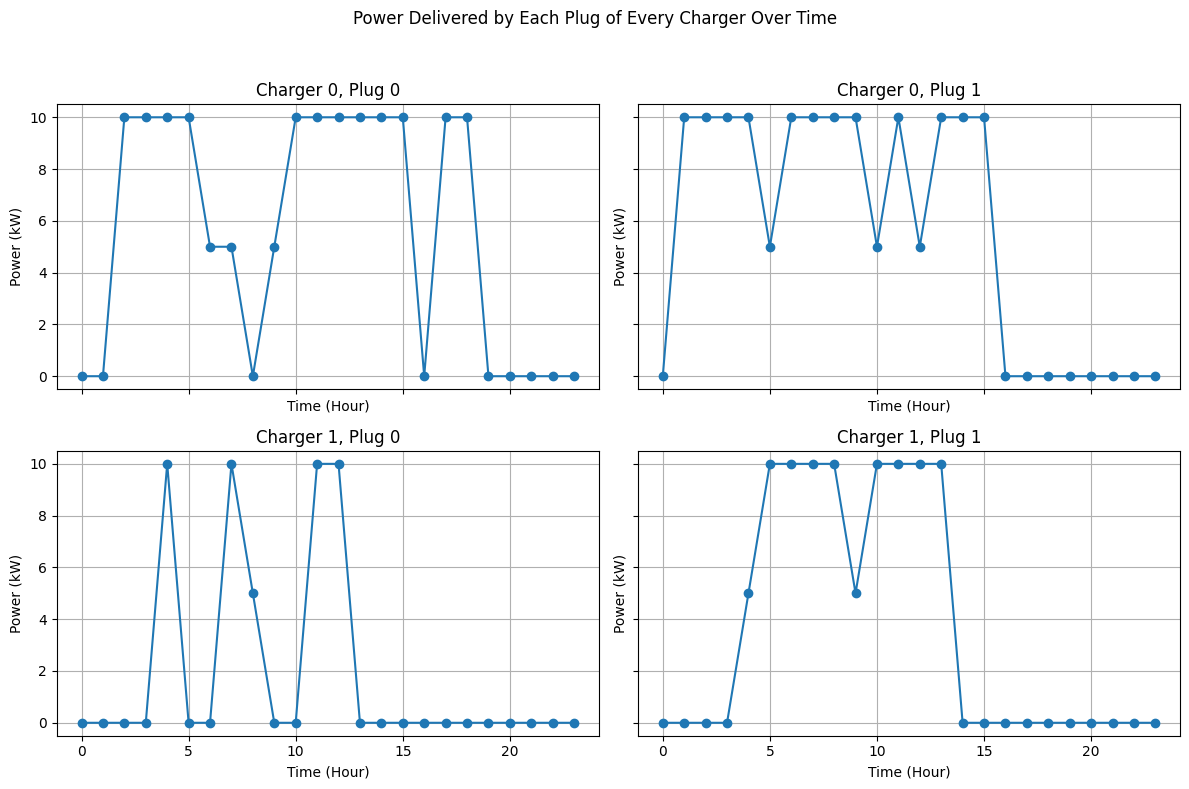

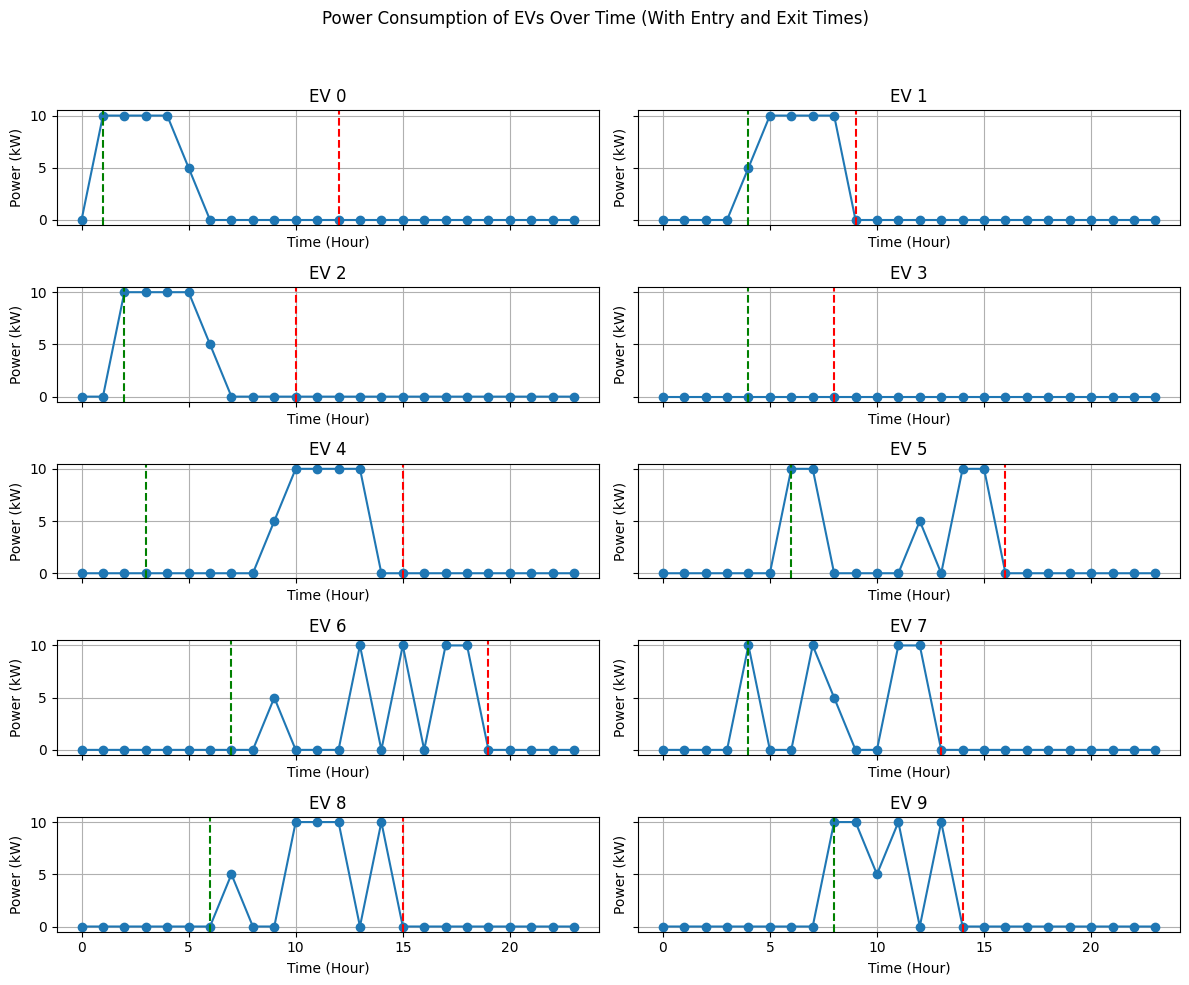

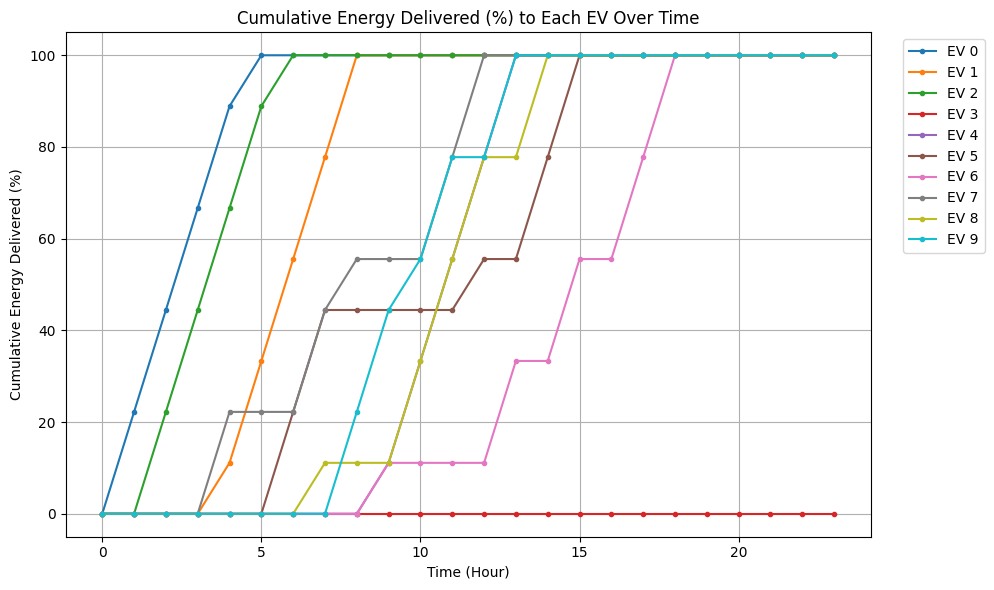

In [185]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Load the CSV results for plotting
plug_power_df = pd.read_csv('plug_power_results.csv')
ev_power_df = pd.read_csv('ev_power_results.csv')

# 1. Power Delivered by Each Plug of Every Charger Over Time
fig, axs = plt.subplots(n_chargers, n_plugs_per_charger, figsize=(12, 8), sharex=True, sharey=True)

for (c, p), group in plug_power_df.groupby(['Charger', 'Plug']):
    ax = axs[c, p]
    ax.plot(group['Hour'], group['Power (kW)'], label=f'Charger {c}, Plug {p}', linestyle='-', marker='o')
    ax.set_title(f'Charger {c}, Plug {p}')
    ax.set_xlabel('Time (Hour)')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)
plt.suptitle('Power Delivered by Each Plug of Every Charger Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Number of EVs
n_vehicles = ev_power_df['Vehicle'].nunique()

# 2. Power Consumption of EVs Over Time (with subplots for each EV)
fig, axs = plt.subplots(n_vehicles // 2, 2, figsize=(12, n_vehicles), sharex=True, sharey=True)  # Adjust the number of rows and columns

# Flatten the axs array in case it is not already 1D
axs = axs.flatten()

# Iterate over each EV and plot its power consumption in a separate subplot
for i, (v, group) in enumerate(ev_power_df.groupby('Vehicle')):
    ax = axs[i]
    ax.plot(group['Hour'], group['Power (kW)'], label=f'EV {v}', linestyle='-', marker='o')
    
    # Mark entry and exit times with vertical lines
    entry_time = arrival_times[v]
    exit_time = departure_times[v]
    
    ax.axvline(x=entry_time, color='green', linestyle='--')  # Mark entry time
    ax.axvline(x=exit_time, color='red', linestyle='--')      # Mark exit time
    
    ax.set_title(f'EV {v}')
    ax.set_xlabel('Time (Hour)')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)

plt.suptitle('Power Consumption of EVs Over Time (With Entry and Exit Times)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 3. Cumulative Energy Delivered to Each EV Over Time
fig, ax = plt.subplots(figsize=(10, 6))

# Create a cumulative sum of the energy delivered for each EV
for v, group in ev_power_df.groupby('Vehicle'):
    cumulative_energy = np.cumsum(group['Power (kW)'])  # Cumulative sum over time
    ax.plot(group['Hour'], cumulative_energy/required_energy[v] * 100, label=f'EV {v}', linestyle='-', marker='.')

ax.set_title('Cumulative Energy Delivered (%) to Each EV Over Time')
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Cumulative Energy Delivered (%)')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.grid(True)
plt.tight_layout()
plt.show()


In [186]:
import csv

# Step 1: Read the CSV file to identify vehicles assigned to Charger 0, Plug 0
vehicles_assigned_to_plug_0 = set()  # Use a set to avoid duplicates

# Assuming the CSV format is: "Charger", "Plug", "Hour", "Power (kW)"
with open('plug_power_results.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    for row in reader:
        charger, plug, hour, power = int(row[0]), int(row[1]), int(row[2]), float(row[3])
        if charger == 0 and plug == 0 and power > 0:
            vehicles_assigned_to_plug_0.add(hour)  # Assuming the hour is a proxy for a vehicle assignment

# Step 2: Initialize data structures to store energy delivered and presence at the station
max_vehicle_id = max(vehicles_assigned_to_plug_0) if vehicles_assigned_to_plug_0 else 0
n_vehicles = max_vehicle_id + 1  # Adjust n_vehicles dynamically based on the maximum vehicle ID

ev_energy_on_plug_0 = {}
ev_at_station_plug_0_time_step = [[0 for _ in range(24)] for _ in range(n_vehicles)]

# Step 3: Track energy delivered and presence for vehicles assigned to Charger 0, Plug 0
current_ev = None

# Loop through each time period for Charger 0, Plug 0
for t in range(24):  # or 96 for 15-minute intervals
    # Check which vehicle is assigned to Charger 0, Plug 0 at this time step
    for v in vehicles_assigned_to_plug_0:
        if v < n_vehicles and vehicle_assigned.get((v, 0, 0, t), None) and vehicle_assigned[v, 0, 0, t].varValue == 1:
            # If a new EV is assigned to this plug, switch to tracking that EV
            if v != current_ev:
                current_ev = v  # Update the current EV
                if current_ev not in ev_energy_on_plug_0:
                    ev_energy_on_plug_0[current_ev] = [0] * 24  # Initialize the array for this EV

            # Sum the power delivered by Charger 0, Plug 0 at this time step for the assigned vehicle
            ev_energy_on_plug_0[current_ev][t] = P_vehicle_t[current_ev, 0, 0, t].varValue

# Print the energy delivered by each EV on Charger 0, Plug 0 at each time step
for ev, energy_array in ev_energy_on_plug_0.items():
    print(f"Energy delivered by Vehicle {ev} on Charger 0, Plug 0 at each time step:")
    for t, energy in enumerate(energy_array):
        print(f"  Time {t}: {energy} kW")

# Loop through each vehicle and time period
for v in vehicles_assigned_to_plug_0:
    if v < n_vehicles:
        is_assigned_to_plug_0 = any(vehicle_assigned.get((v, 0, 0, t), None) and vehicle_assigned[v, 0, 0, t].varValue == 1 for t in range(24))  # Check if assigned to Plug 0

        if is_assigned_to_plug_0:
            for t in range(24):  # or 96 for 15-minute intervals
                # Mark 1 if the vehicle is within its arrival and departure time window
                if arrival_times[v] <= t < departure_times[v]:
                    ev_at_station_plug_0_time_step[v][t] = 1

# Print the result array only for vehicles assigned to Plug 0 of Charger 0
for v in vehicles_assigned_to_plug_0:
    if v < n_vehicles and any(ev_at_station_plug_0_time_step[v]):  # Only print if the vehicle was assigned to Plug 0
        print(f"Vehicle {v} presence at the charging station (assigned to Plug 0) at each time step:")
        print(ev_at_station_plug_0_time_step[v])









Energy delivered by Vehicle 2 on Charger 0, Plug 0 at each time step:
  Time 0: 0 kW
  Time 1: 0 kW
  Time 2: 10.0 kW
  Time 3: 10.0 kW
  Time 4: 10.0 kW
  Time 5: 10.0 kW
  Time 6: 5.0 kW
  Time 7: 0 kW
  Time 8: 0 kW
  Time 9: 0 kW
  Time 10: 0 kW
  Time 11: 0 kW
  Time 12: 0 kW
  Time 13: 0 kW
  Time 14: 0 kW
  Time 15: 0 kW
  Time 16: 0 kW
  Time 17: 0 kW
  Time 18: 0 kW
  Time 19: 0 kW
  Time 20: 0 kW
  Time 21: 0 kW
  Time 22: 0 kW
  Time 23: 0 kW
Energy delivered by Vehicle 6 on Charger 0, Plug 0 at each time step:
  Time 0: 0 kW
  Time 1: 0 kW
  Time 2: 0 kW
  Time 3: 0 kW
  Time 4: 0 kW
  Time 5: 0 kW
  Time 6: 0 kW
  Time 7: 0 kW
  Time 8: 0 kW
  Time 9: 5.0 kW
  Time 10: 0 kW
  Time 11: 0 kW
  Time 12: 0 kW
  Time 13: 10.0 kW
  Time 14: 0 kW
  Time 15: 10.0 kW
  Time 16: 0.0 kW
  Time 17: 10.0 kW
  Time 18: 10.0 kW
  Time 19: 0 kW
  Time 20: 0 kW
  Time 21: 0 kW
  Time 22: 0 kW
  Time 23: 0 kW
Vehicle 2 presence at the charging station (assigned to Plug 0) at each time step:

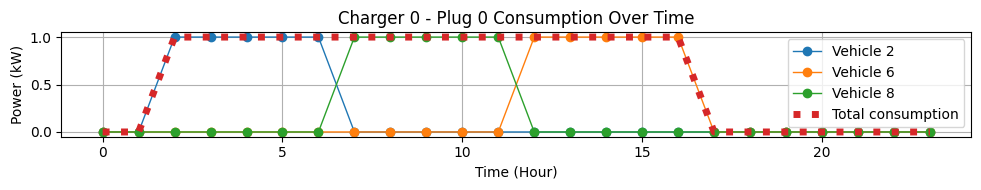

Final charging schedule for Charger 0, Plug 0, with vehicle assignments:
Time 0: No vehicle is charging.
Time 1: No vehicle is charging.
Time 2: Vehicle 2 is charging.
Time 3: Vehicle 2 is charging.
Time 4: Vehicle 2 is charging.
Time 5: Vehicle 2 is charging.
Time 6: Vehicle 2 is charging.
Time 7: Vehicle 8 is charging.
Time 8: Vehicle 8 is charging.
Time 9: Vehicle 8 is charging.
Time 10: Vehicle 8 is charging.
Time 11: Vehicle 8 is charging.
Time 12: Vehicle 6 is charging.
Time 13: Vehicle 6 is charging.
Time 14: Vehicle 6 is charging.
Time 15: Vehicle 6 is charging.
Time 16: Vehicle 6 is charging.
Time 17: No vehicle is charging.
Time 18: No vehicle is charging.
Time 19: No vehicle is charging.
Time 20: No vehicle is charging.
Time 21: No vehicle is charging.
Time 22: No vehicle is charging.
Time 23: No vehicle is charging.


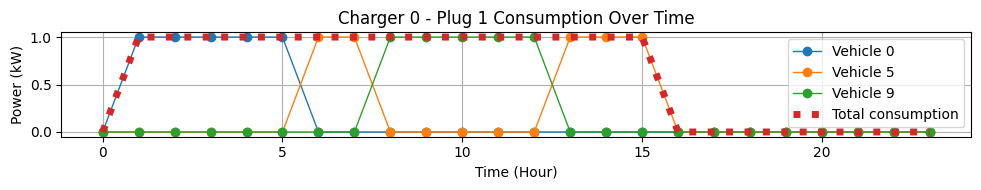

Final charging schedule for Charger 0, Plug 1, with vehicle assignments:
Time 0: No vehicle is charging.
Time 1: Vehicle 0 is charging.
Time 2: Vehicle 0 is charging.
Time 3: Vehicle 0 is charging.
Time 4: Vehicle 0 is charging.
Time 5: Vehicle 0 is charging.
Time 6: Vehicle 5 is charging.
Time 7: Vehicle 5 is charging.
Time 8: Vehicle 9 is charging.
Time 9: Vehicle 9 is charging.
Time 10: Vehicle 9 is charging.
Time 11: Vehicle 9 is charging.
Time 12: Vehicle 9 is charging.
Time 13: Vehicle 5 is charging.
Time 14: Vehicle 5 is charging.
Time 15: Vehicle 5 is charging.
Time 16: No vehicle is charging.
Time 17: No vehicle is charging.
Time 18: No vehicle is charging.
Time 19: No vehicle is charging.
Time 20: No vehicle is charging.
Time 21: No vehicle is charging.
Time 22: No vehicle is charging.
Time 23: No vehicle is charging.


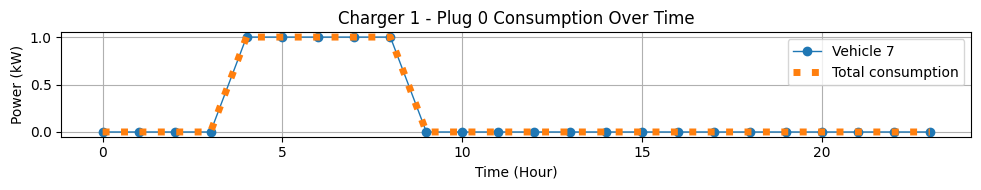

Final charging schedule for Charger 1, Plug 0, with vehicle assignments:
Time 0: No vehicle is charging.
Time 1: No vehicle is charging.
Time 2: No vehicle is charging.
Time 3: No vehicle is charging.
Time 4: Vehicle 7 is charging.
Time 5: Vehicle 7 is charging.
Time 6: Vehicle 7 is charging.
Time 7: Vehicle 7 is charging.
Time 8: Vehicle 7 is charging.
Time 9: No vehicle is charging.
Time 10: No vehicle is charging.
Time 11: No vehicle is charging.
Time 12: No vehicle is charging.
Time 13: No vehicle is charging.
Time 14: No vehicle is charging.
Time 15: No vehicle is charging.
Time 16: No vehicle is charging.
Time 17: No vehicle is charging.
Time 18: No vehicle is charging.
Time 19: No vehicle is charging.
Time 20: No vehicle is charging.
Time 21: No vehicle is charging.
Time 22: No vehicle is charging.
Time 23: No vehicle is charging.


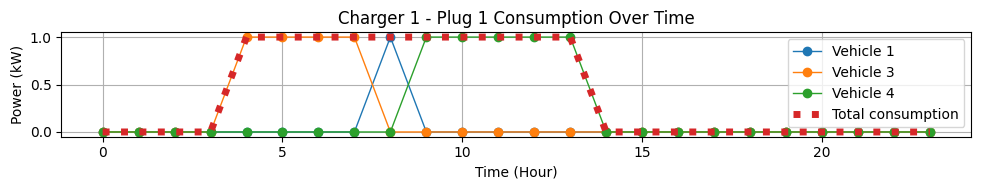

Final charging schedule for Charger 1, Plug 1, with vehicle assignments:
Time 0: No vehicle is charging.
Time 1: No vehicle is charging.
Time 2: No vehicle is charging.
Time 3: No vehicle is charging.
Time 4: Vehicle 3 is charging.
Time 5: Vehicle 3 is charging.
Time 6: Vehicle 3 is charging.
Time 7: Vehicle 3 is charging.
Time 8: Vehicle 1 is charging.
Time 9: Vehicle 4 is charging.
Time 10: Vehicle 4 is charging.
Time 11: Vehicle 4 is charging.
Time 12: Vehicle 4 is charging.
Time 13: Vehicle 4 is charging.
Time 14: No vehicle is charging.
Time 15: No vehicle is charging.
Time 16: No vehicle is charging.
Time 17: No vehicle is charging.
Time 18: No vehicle is charging.
Time 19: No vehicle is charging.
Time 20: No vehicle is charging.
Time 21: No vehicle is charging.
Time 22: No vehicle is charging.
Time 23: No vehicle is charging.

Charging Summary:
Vehicle 0 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 1 did NOT fully charge. (Needed: 5 time steps, Charged: 1

In [187]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv

# Load the vehicle data from the CSV file
vehicle_data = pd.read_csv('vehicle_plug_assignments.csv')

# Define number of chargers and plugs per charger
n_chargers = vehicle_data['Charger'].nunique()  # Get the number of unique chargers
n_plugs_per_charger = vehicle_data['Plug'].nunique()  # Get the number of unique plugs

# Dictionary to track total charge time for each vehicle
vehicle_charging_summary = {v: {'charged_time': 0, 'charge_needed': 0} for v in vehicle_data['Vehicle'].unique()}

# Loop through all charger and plug combinations
for charger in range(n_chargers):
    for plug in range(n_plugs_per_charger):
        # Filter vehicle data for the current charger and plug
        filtered_vehicle_data = vehicle_data[(vehicle_data['Charger'] == charger) & (vehicle_data['Plug'] == plug)]

        # Create a dictionary to store the filtered vehicle data
        vehicles = {}

        # Populate the vehicle dictionary with filtered data from the CSV file
        for _, row in filtered_vehicle_data.iterrows():
            vehicle_id = int(row['Vehicle'])
            arrival = int(row['Arrival'])
            departure = int(row['Departure'])
            required_energy = float(row['RequiredEnergy'])

            # Calculate charge_needed (rounding up if necessary)
            charge_needed = math.ceil(required_energy / max_plug_power)

            vehicles[vehicle_id] = {
                'arrival': arrival,
                'departure': departure,
                'charge_needed': charge_needed
            }

            # Add the charge_needed to the summary for this vehicle
            vehicle_charging_summary[vehicle_id]['charge_needed'] = charge_needed

        # Sort vehicles by their ability to fully charge (vehicles that can fully charge are prioritized)
        sorted_vehicles = sorted(vehicles.items(), key=lambda v: (v[1]['departure'] - v[1]['arrival']) - v[1]['charge_needed'])

        # Create an empty schedule for 24 hours where each entry corresponds to the vehicle charging at that time (-1 means no vehicle)
        charging_schedule = [-1] * 24

        # Function to check if a vehicle can charge continuously later
        def can_charge_continuously(vehicle_id, arrival, departure, charge_needed, charging_schedule):
            # Check if there is enough consecutive time between arrival and departure to charge continuously
            for start_time in range(arrival, departure - charge_needed + 1):
                if all(charging_schedule[t] == -1 for t in range(start_time, start_time + charge_needed )):
                    return start_time
            return -1  # No continuous block found

        # Function to schedule charging for each vehicle
        def schedule_charging(vehicle_id, arrival, departure, charge_needed, charging_schedule):
            # Check if the vehicle can charge continuously later within its time window
            start_time = can_charge_continuously(vehicle_id, arrival, departure, charge_needed, charging_schedule)
            if start_time != -1:
                # Charge continuously starting from the optimal time
                for t in range(start_time, start_time + charge_needed):
                    charging_schedule[t] = vehicle_id
                return charge_needed
            else:
                # Charge at the earliest available times
                continuous_charge_time = 0  # To track how many time steps we've assigned
                for t in range(arrival, departure):
                    if charging_schedule[t] == -1:  # If no vehicle is charging at this time
                        charging_schedule[t] = vehicle_id
                        continuous_charge_time += 1
                    if continuous_charge_time >= charge_needed:
                        break
                return continuous_charge_time

        # Iterate over each vehicle (in the optimized order) and assign them charging times
        for vehicle_id, data in sorted_vehicles:
            # Only assign time steps to vehicles that have enough time to fully charge
            total_charge_time = schedule_charging(vehicle_id, data['arrival'], data['departure'], data['charge_needed'], charging_schedule)
            vehicle_charging_summary[vehicle_id]['charged_time'] += total_charge_time

        # Convert the charging schedule into a DataFrame for plotting
        time_steps = list(range(24))
        df = pd.DataFrame({
            'Time': time_steps,
            **{f'Vehicle {v}': [1 if vehicle == v else 0 for vehicle in charging_schedule] for v in vehicles.keys()},
            'Total consumption': [1 if vehicle != -1 else 0 for vehicle in charging_schedule],
        }).set_index('Time')

        # Plot the graph for the current charger and plug
        plt.figure(figsize=(10, 2))

        # Plot each EV's consumption along with the total consumption
        for column in df.columns:
            if column != 'Total consumption':
                plt.plot(df.index, df[column], label=column, marker='o', linewidth=1)
            else:
                plt.plot(df.index, df[column], label=column, linewidth=5, linestyle=':')

        plt.title(f'Charger {charger} - Plug {plug} Consumption Over Time')
        plt.xlabel('Time (Hour)')
        plt.ylabel('Power (kW)')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()

        # Show the plot
        plt.show()

        # Print the final schedule
        print(f"Final charging schedule for Charger {charger}, Plug {plug}, with vehicle assignments:")
        for t, vehicle in enumerate(charging_schedule):
            if vehicle != -1:
                print(f"Time {t}: Vehicle {vehicle} is charging.")
            else:
                print(f"Time {t}: No vehicle is charging.")

# Summary: Print which vehicles fully charged and which did not
print("\nCharging Summary:")
for vehicle_id, summary in vehicle_charging_summary.items():
    if summary['charged_time'] >= summary['charge_needed']:
        print(f"Vehicle {vehicle_id} fully charged. (Needed: {summary['charge_needed']} time steps, Charged: {summary['charged_time']} time steps)")
    else:
        print(f"Vehicle {vehicle_id} did NOT fully charge. (Needed: {summary['charge_needed']} time steps, Charged: {summary['charged_time']} time steps)")


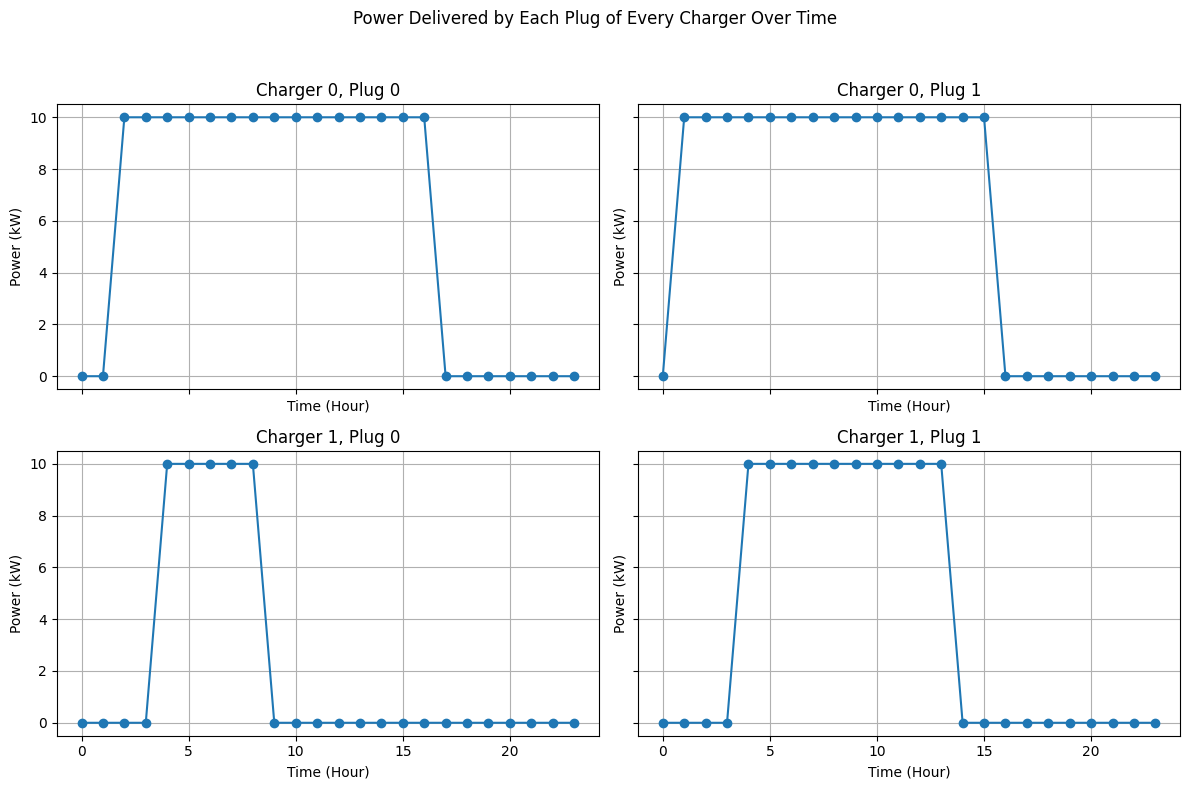

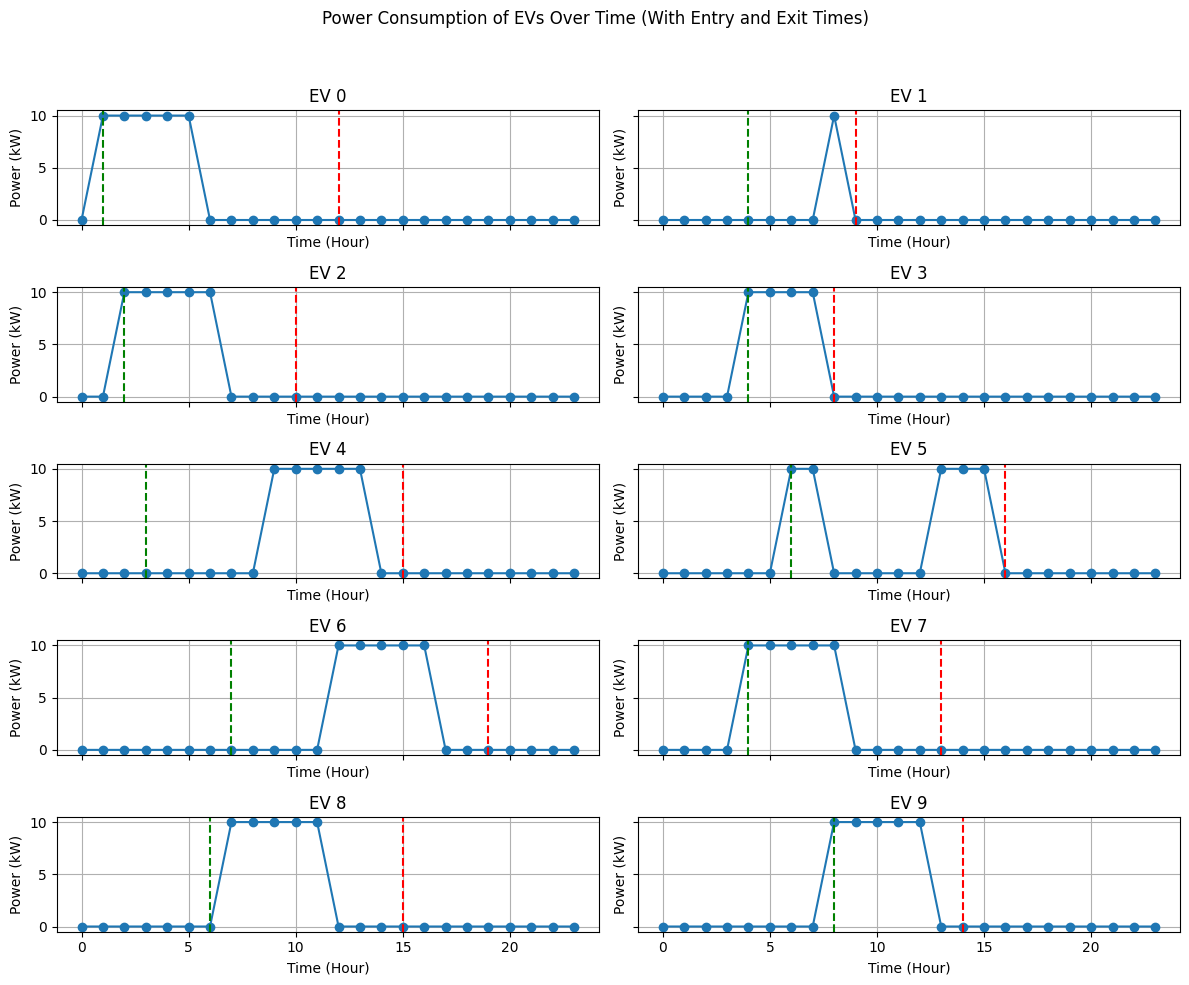

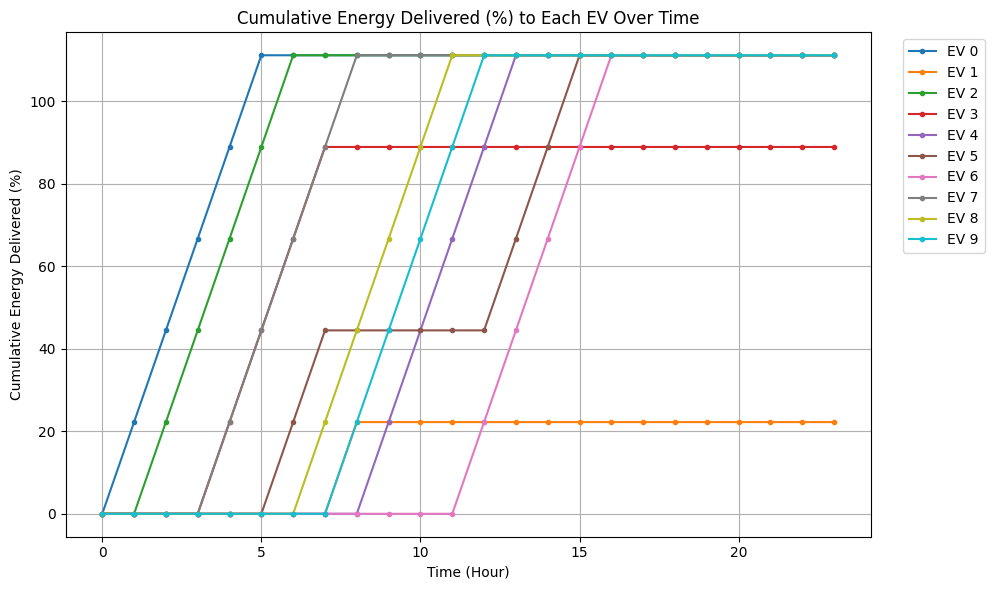


Charging Summary:
Vehicle 0 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 1 did NOT fully charge. (Needed: 5 time steps, Charged: 1 time steps)
Vehicle 2 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 3 did NOT fully charge. (Needed: 5 time steps, Charged: 4 time steps)
Vehicle 4 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 5 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 6 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 7 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 8 fully charged. (Needed: 5 time steps, Charged: 5 time steps)
Vehicle 9 fully charged. (Needed: 5 time steps, Charged: 5 time steps)


In [188]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv

# Load the vehicle data from the CSV file
vehicle_data = pd.read_csv('vehicle_plug_assignments.csv')

# Define number of chargers and plugs per charger
n_chargers = vehicle_data['Charger'].nunique()  # Get the number of unique chargers
n_plugs_per_charger = vehicle_data['Plug'].nunique()  # Get the number of unique plugs

# Dictionary to track total charge time for each vehicle
vehicle_charging_summary = {v: {'charged_time': 0, 'charge_needed': 0} for v in vehicle_data['Vehicle'].unique()}

# Data for power delivered by each plug for graphing
plug_power_results = []
ev_power_results = []

# Loop through all charger and plug combinations
for charger in range(n_chargers):
    for plug in range(n_plugs_per_charger):
        # Filter vehicle data for the current charger and plug
        filtered_vehicle_data = vehicle_data[(vehicle_data['Charger'] == charger) & (vehicle_data['Plug'] == plug)]

        # Create a dictionary to store the filtered vehicle data
        vehicles = {}

        # Populate the vehicle dictionary with filtered data from the CSV file
        for _, row in filtered_vehicle_data.iterrows():
            vehicle_id = int(row['Vehicle'])
            arrival = int(row['Arrival'])
            departure = int(row['Departure'])
            required_energy = float(row['RequiredEnergy'])

            # Calculate charge_needed (rounding up if necessary)
            charge_needed = math.ceil(required_energy / max_plug_power)

            vehicles[vehicle_id] = {
                'arrival': arrival,
                'departure': departure,
                'charge_needed': charge_needed
            }

            # Add the charge_needed to the summary for this vehicle
            vehicle_charging_summary[vehicle_id]['charge_needed'] = charge_needed

        # Sort vehicles by their ability to fully charge (vehicles that can fully charge are prioritized)
        sorted_vehicles = sorted(vehicles.items(), key=lambda v: (v[1]['departure'] - v[1]['arrival']) - v[1]['charge_needed'])

        # Create an empty schedule for 24 hours where each entry corresponds to the vehicle charging at that time (-1 means no vehicle)
        charging_schedule = [-1] * 24

        # Function to check if a vehicle can charge continuously later
        def can_charge_continuously(vehicle_id, arrival, departure, charge_needed, charging_schedule):
            # Check if there is enough consecutive time between arrival and departure to charge continuously
            for start_time in range(arrival, departure - charge_needed + 1):
                if all(charging_schedule[t] == -1 for t in range(start_time, start_time + charge_needed)):
                    return start_time
            return -1  # No continuous block found

        # Function to schedule charging for each vehicle
        def schedule_charging(vehicle_id, arrival, departure, charge_needed, charging_schedule):
            # Check if the vehicle can charge continuously later within its time window
            start_time = can_charge_continuously(vehicle_id, arrival, departure, charge_needed, charging_schedule)
            if start_time != -1:
                # Charge continuously starting from the optimal time
                for t in range(start_time, start_time + charge_needed):
                    charging_schedule[t] = vehicle_id
                return charge_needed
            else:
                # Charge at the earliest available times
                continuous_charge_time = 0  # To track how many time steps we've assigned
                for t in range(arrival, departure):
                    if charging_schedule[t] == -1:  # If no vehicle is charging at this time
                        charging_schedule[t] = vehicle_id
                        continuous_charge_time += 1
                    if continuous_charge_time >= charge_needed:
                        break
                return continuous_charge_time

        # Iterate over each vehicle (in the optimized order) and assign them charging times
        for vehicle_id, data in sorted_vehicles:
            total_charge_time = schedule_charging(vehicle_id, data['arrival'], data['departure'], data['charge_needed'], charging_schedule)
            vehicle_charging_summary[vehicle_id]['charged_time'] += total_charge_time

        # Store the plug's power results for plotting
        for t in range(24):
            total_power = max_plug_power if charging_schedule[t] != -1 else 0
            plug_power_results.append([charger, plug, t, total_power])

        # Store the EV's power results for plotting
        for vehicle_id in vehicles.keys():
            for t in range(24):
                power = max_plug_power if charging_schedule[t] == vehicle_id else 0
                ev_power_results.append([vehicle_id, t, power])

# Convert plug and EV power results to DataFrames
plug_power_df = pd.DataFrame(plug_power_results, columns=['Charger', 'Plug', 'Hour', 'Power (kW)'])
ev_power_df = pd.DataFrame(ev_power_results, columns=['Vehicle', 'Hour', 'Power (kW)'])

# Plot 1: Power Delivered by Each Plug of Every Charger Over Time
fig, axs = plt.subplots(n_chargers, n_plugs_per_charger, figsize=(12, 8), sharex=True, sharey=True)

for (c, p), group in plug_power_df.groupby(['Charger', 'Plug']):
    ax = axs[c, p]
    ax.plot(group['Hour'], group['Power (kW)'], label=f'Charger {c}, Plug {p}', linestyle='-', marker='o')
    ax.set_title(f'Charger {c}, Plug {p}')
    ax.set_xlabel('Time (Hour)')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)

plt.suptitle('Power Delivered by Each Plug of Every Charger Over Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Number of EVs
n_vehicles = ev_power_df['Vehicle'].nunique()

# Plot 2: Power Consumption of EVs Over Time (with subplots for each EV)
fig, axs = plt.subplots(n_vehicles // 2, 2, figsize=(12, n_vehicles), sharex=True, sharey=True)





# Flatten the axs array in case it is not already 1D
axs = axs.flatten()

for i, (v, group) in enumerate(ev_power_df.groupby('Vehicle')):
    ax = axs[i]
    ax.plot(group['Hour'], group['Power (kW)'], label=f'EV {v}', linestyle='-', marker='o')
    
    # Mark entry and exit times with vertical lines
    entry_time = vehicle_data[vehicle_data['Vehicle'] == v]['Arrival'].values[0]
    exit_time = vehicle_data[vehicle_data['Vehicle'] == v]['Departure'].values[0]
    
    ax.axvline(x=entry_time, color='green', linestyle='--')  # Mark entry time
    ax.axvline(x=exit_time, color='red', linestyle='--')      # Mark exit time
    
    ax.set_title(f'EV {v}')
    ax.set_xlabel('Time (Hour)')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)

plt.suptitle('Power Consumption of EVs Over Time (With Entry and Exit Times)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot 3: Cumulative Energy Delivered to Each EV Over Time
fig, ax = plt.subplots(figsize=(10, 6))

# Create a cumulative sum of the energy delivered for each EV
for v, group in ev_power_df.groupby('Vehicle'):
    cumulative_energy = np.cumsum(group['Power (kW)'])  # Cumulative sum over time
    required_energy = vehicle_data[vehicle_data['Vehicle'] == v]['RequiredEnergy'].values[0]
    ax.plot(group['Hour'], cumulative_energy / required_energy * 100, label=f'EV {v}', linestyle='-', marker='.')

ax.set_title('Cumulative Energy Delivered (%) to Each EV Over Time')
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Cumulative Energy Delivered (%)')
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax.grid(True)
plt.tight_layout()
plt.show()

# Summary: Print which vehicles fully charged and which did not
print("\nCharging Summary:")
for vehicle_id, summary in vehicle_charging_summary.items():
    if summary['charged_time'] >= summary['charge_needed']:
        print(f"Vehicle {vehicle_id} fully charged. (Needed: {summary['charge_needed']} time steps, Charged: {summary['charged_time']} time steps)")
    else:
        print(f"Vehicle {vehicle_id} did NOT fully charge. (Needed: {summary['charge_needed']} time steps, Charged: {summary['charged_time']} time steps)")
